## 데이터마이닝 프로젝트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
# 데이터 로드

FP_PATH    = "floating_population.csv"   # 유동인구
SALES_PATH = "sales.csv"                 # 매출
STORE_PATH = "store.csv"                 # 점포


In [79]:
def read_korean_csv(path: str) -> pd.DataFrame:
    """Try common Korean encodings."""
    for enc in ("utf-8", "cp949", "euc-kr"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path)

fp    = read_korean_csv(FP_PATH)
fp = fp[fp["기준_년분기_코드"] // 10 == 2024]
sales = read_korean_csv(SALES_PATH)
store = read_korean_csv(STORE_PATH)

print(fp.shape, sales.shape, store.shape)


(1700, 25) (67900, 53) (141001, 12)


In [80]:
f = lambda x: display(x["기준_년분기_코드"].unique())
f(fp)
f(sales)
f(store)

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

In [18]:
def get_columns(df):
    display(df.columns)
get_columns(fp)
get_columns(sales)
get_columns(store)

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
       '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수',
       '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수',
       '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수',
       '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
       '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '남성_매출_건수', '여성_매출_건수',
       '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수',
       '연령대_50_매출_건수', '연령대_60_이상_매출_건수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '점포_수',
       '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수'],
      dtype='object')

In [106]:
#데이터 전처리
def make_numeric(df, drop_cols):
    return [c for c in df.columns if c not in drop_cols and df[c].dtype != 'object']

sales_num = make_numeric(sales, ["행정동_코드", "기준_년분기_코드"])
store_num = make_numeric(store, ["행정동_코드", "기준_년분기_코드"])

sales_agg = (sales
             .groupby(["기준_년분기_코드", "행정동_코드"])[sales_num]
             .sum()
             .reset_index())

store_agg = (store
             .groupby(["기준_년분기_코드", "행정동_코드"])[store_num]
             .median() # 0 값이 많아 median과 차이가 있는데 어떤 걸로 할지?
             .reset_index())

merged = (fp
          .merge(sales_agg, on=["기준_년분기_코드", "행정동_코드"], how="left")
          .merge(store_agg, on=["기준_년분기_코드", "행정동_코드"], how="left"))
merged = merged.dropna(axis=0)
print("Merged:", merged.shape)


Merged: (1696, 80)


In [107]:
merged.isna().sum().sum()

np.int64(0)

In [108]:
# 표준화 후 PCA 분석
feature_cols = [c for c in merged.columns
                if c not in ("행정동_코드", "기준_년분기_코드") and merged[c].dtype != 'object']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged[feature_cols])

pca = PCA(n_components=0.95, random_state=42, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print(f"PCA → {X_pca.shape[1]} components (cum var {pca.explained_variance_ratio_.sum():.2%})")


PCA → 8 components (cum var 95.74%)


In [109]:
print(f"PCA → {X_pca.shape[1]} components (each var \n{pca.explained_variance_ratio_})")

PCA → 8 components (each var 
[0.59962859 0.19613529 0.05014427 0.0322328  0.02722543 0.02139378
 0.01797096 0.01270912])


-> 8개 주성분으로 원본 데이터의 분산 95.05% 설명 가능

In [110]:
loadings = pd.DataFrame(
    pca.components_.T,                         # (변수 개수 × 주성분 개수) 행렬
    index=feature_cols,                        # 행 = 원본 변수 이름
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

In [111]:
len(merged.columns)

80

In [112]:
for pc in loadings.columns:          # 'PC1' … 'PC7'
    top = (loadings[pc]
           .sort_values(ascending=False, key=abs)
           .head(30))                # 상위 8개 변수
    print(f"\n{pc} 상위 기여 변수:")
    print(top)


PC1 상위 기여 변수:
남성_매출_건수           0.141352
당월_매출_건수           0.141075
금요일_매출_건수          0.140736
주중_매출_건수           0.139775
수요일_매출_건수          0.139446
목요일_매출_건수          0.139255
월요일_매출_건수          0.138997
화요일_매출_건수          0.138848
시간대_건수~21_매출_건수    0.138278
여성_매출_건수           0.137348
연령대_50_매출_건수       0.135436
연령대_40_매출_건수       0.134974
시간대_건수~14_매출_건수    0.134890
여성_매출_금액           0.134807
목요일_매출_금액          0.133696
토요일_매출_건수          0.133625
주중_매출_금액           0.133537
주말_매출_건수           0.133070
수요일_매출_금액          0.133004
당월_매출_금액           0.132907
월요일_매출_금액          0.132821
시간대_건수~11_매출_건수    0.132282
금요일_매출_금액          0.132225
화요일_매출_금액          0.131686
시간대_건수~17_매출_건수    0.131301
일요일_매출_건수          0.131245
연령대_30_매출_건수       0.130694
시간대_11~14_매출_금액    0.130645
남성_매출_금액           0.129985
연령대_30_매출_금액       0.129060
Name: PC1, dtype: float64

PC2 상위 기여 변수:
시간대_00_06_유동인구_수    0.214037
시간대_21_24_유동인구_수    0.208439
일요일_유동인구_수          0.205890
여성_유동인구_수        

In [113]:
# kmeans Clustering 사용하기 위해 k 설정하는 과정(지표 비교)

def eval_k(X, k):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    labels = km.labels_
    return {
        "k": k,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X, labels, sample_size=min(5000, len(X)), random_state=42),
        "calinski": calinski_harabasz_score(X, labels),
        "davies": davies_bouldin_score(X, labels)
    }

scores = pd.DataFrame([eval_k(X_pca, k) for k in range(2, 11)])
display(scores.set_index("k").round(2))

best_k = scores.loc[scores['silhouette'].idxmax(), 'k']
print("Best k (silhouette):", best_k)


,inertia,silhouette,calinski,davies
k,,,,
2,80093.31,0.71,916.17,0.97
3,57029.05,0.45,985.32,0.98
4,45729.27,0.42,958.07,1.02
5,39814.33,0.38,887.62,0.99
6,33966.99,0.38,890.04,1.05
7,30759.73,0.38,847.91,0.91
8,27997.56,0.38,821.80,0.83
9,26284.09,0.38,779.25,0.84
10,23920.04,0.32,779.17,0.98


Best k (silhouette): 2


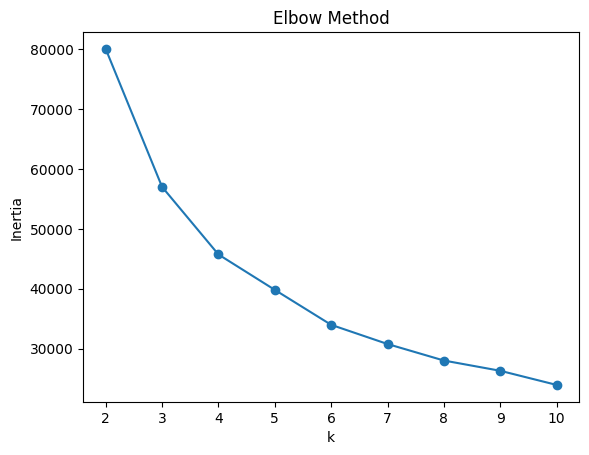

In [114]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ks, inertias = [], []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
    ks.append(k)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, 'o-')
plt.title("Elbow Method")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

In [115]:
### silhouette score는 k=2에서 제일 높았지만, 2개의 클러스터는 적다고 느껴지기도 하고 엘보우 메소드를 참고해서 k=4로 해봤습니다!

In [131]:
# kmeans 클러스터링 적용
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
merged['cluster'] = kmeans.fit_predict(X_pca)
merged['cluster'].value_counts().sort_index()


cluster
0    1004
1     122
2     548
3      22
Name: count, dtype: int64

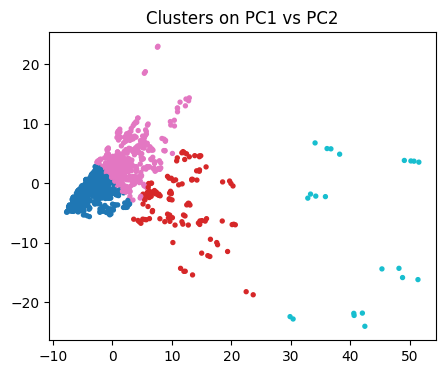

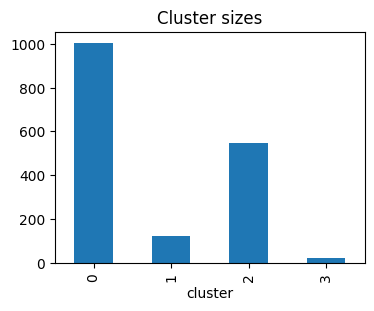

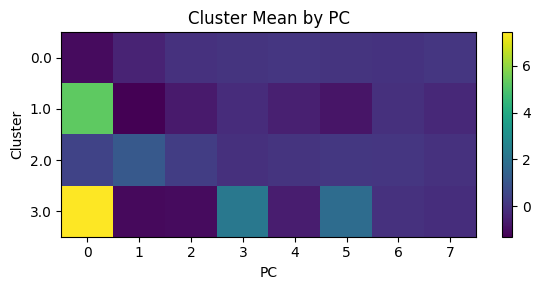

In [132]:
# 시각화
plt.figure(figsize=(5,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=merged['cluster'], s=8, cmap='tab10')
plt.title('Clusters on PC1 vs PC2')
plt.show()  #PCA 1·2 축 산점도

plt.figure(figsize=(4,3))
merged['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('Cluster sizes')
plt.show() #cluster 별 크기

pc_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pc_df["cluster"] = merged["cluster"]
mean_matrix = pc_df.groupby("cluster").mean()

plt.figure(figsize=(6,3))
plt.imshow(mean_matrix, aspect="auto"); plt.colorbar()
plt.yticks(range(len(mean_matrix)), mean_matrix.index)
plt.title("Cluster Mean by PC"); plt.xlabel("PC"); plt.ylabel("Cluster")
plt.tight_layout(); plt.show() #군집별 PC 평균 Heatmap



In [1]:
from sklearn.manifold import TSNE

for i in [10, 30, 50, 70]:
    tsne_model = TSNE(
        n_components=2,      # 축소할 차원 (보통 2 또는 3)
        perplexity=i,     # 가장 중요한 파라미터 중 하나. 데이터 포인트 주변의 로컬 이웃 수와 관련. (5 ~ 50 사이 값 권장)
        learning_rate='auto',# 최적화 과정에서의 학습률. 'auto' (scikit-learn 1.2 이상) 또는 10 ~ 1000 사이 값.
                            # 이전 버전에서는 learning_rate=200.0 이 기본값이었음.
        n_iter=1000,         # 최적화를 위한 반복 횟수 (최소 250, 보통 1000 이상 권장)
        init='pca',          # 초기 임베딩 방법 ('random' 또는 'pca'). 'pca'가 더 안정적이고 좋은 결과를 주는 경향이 있음.
        random_state=42      # 결과 재현을 위한 시드 값
    )

    # t-SNE 적용 (원본 X 또는 X_scaled 사용)
    tsne_results = tsne_model.fit_transform(X_scaled) # 또는 X_scaled

    # 2D 시각화
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=merged["cluster"], cmap='viridis', alpha=0.7)


    plt.title('t-SNE visualization of data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

NameError: name 'X_scaled' is not defined

In [133]:
#PC 평균
display(
    mean_matrix.round(2)
               .style.background_gradient(cmap="Blues", axis=None)
               .set_caption("클러스터별 주성분 평균")
)
#원본 변수 — 변별력 상위 8개
cluster_avg = merged.groupby("cluster")[feature_cols].mean()
top_vars = cluster_avg.var().sort_values(ascending=False).head(8).index

display(
    cluster_avg[top_vars].T.round(1)
               .style.background_gradient(cmap="YlOrRd", axis=1)
               .set_caption("클러스터별 평균 — 변별력 상위 8개 변수")
)

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.